In [2]:
import pandas as pd
import yfinance as yf

In [3]:
# replace with your own path
path = "data/options_dataset.parquet"

df = pd.read_parquet(path)

In [4]:
print(df.columns)

Index(['optionid', 'ticker', 'date', 'exdate', 'cp_flag', 'strike_price',
       'best_bid', 'best_offer', 'volume', 'open_interest', 'impl_volatility',
       'delta', 'gamma', 'vega', 'theta'],
      dtype='object')


In [5]:
spx_data = pd.read_csv("data/spx.csv", parse_dates=["date"], index_col="date")
print(spx_data.columns)

Index(['secid', 'ticker', 'index_flag', 'low', 'high', 'open', 'close',
       'volume'],
      dtype='object')


In [6]:
df["strike_price"] = df["strike_price"]/1000

In [11]:
import numpy as np
import pandas as pd

# ---- assumes df (options) and spx_data (underlying) already loaded ----
# df has: ['optionid','ticker','date','exdate','cp_flag','strike_price',
#          'best_bid','best_offer','delta','gamma','vega','theta']
# spx_data has DatetimeIndex and 'close' column.
# strike_price already divided by 1000

df["date"] = pd.to_datetime(df["date"])
df["exdate"] = pd.to_datetime(df["exdate"])
spx_data.index = pd.to_datetime(spx_data.index)
df["mid"] = (df["best_bid"] + df["best_offer"]) * 0.5

# --- parameters ---
ticker0     = "SPX"
start_date  = pd.Timestamp("2020-01-01")
target_days = 21
min_days, max_days = 14, 35
m0 = 1.00   # moneyness level

# --- find trading calendar ---
opt_dates = df.loc[df["ticker"] == ticker0, "date"].drop_duplicates()
common_dates = pd.Index(opt_dates)[opt_dates >= start_date].intersection(
    spx_data.index[spx_data.index >= start_date]
)
current_date = common_dates.min()

rows = []

while True:
    # ========== 1) INITIALIZE PERIOD ==========
    S0 = float(spx_data.loc[current_date, "close"])
    univ = df[(df["ticker"] == ticker0) & (df["date"] == current_date)].copy()
    univ["dte"] = (univ["exdate"] - current_date).dt.days
    cands = univ[(univ["dte"] >= min_days) & (univ["dte"] <= max_days)]
    if cands.empty:
        break

    ex_pick = cands.loc[(cands["dte"] - target_days).abs().idxmin(), "exdate"]
    K_target = m0 * S0
    slice_exp = cands[cands["exdate"] == ex_pick].copy()
    strike_pick = slice_exp.loc[
        (slice_exp["strike_price"] - K_target).abs().idxmin(), "strike_price"
    ]

    call_row0 = slice_exp[
        (slice_exp["strike_price"] == strike_pick)
        & (slice_exp["cp_flag"].str.upper() == "C")
    ].iloc[0]
    put_row0 = slice_exp[
        (slice_exp["strike_price"] == strike_pick)
        & (slice_exp["cp_flag"].str.upper() == "P")
    ].iloc[0]
    call_id, put_id = call_row0["optionid"], put_row0["optionid"]

    # entry cost (buy both legs at offer)
    straddle_cash = -(
        float(call_row0["best_offer"]) + float(put_row0["best_offer"])
    )

    cash_hedge = 0.0
    phi_opt = 0.0
    phi_und = 0.0
    prev_value_total = None

    period_dates = common_dates[
        (common_dates >= current_date) & (common_dates <= ex_pick)
    ]

    # ========== 2) DAILY LOOP ==========
    for d in period_dates:
        S = float(spx_data.loc[d, "close"])

        today = df[
            (df["ticker"] == ticker0) & (df["date"] == d) & (df["exdate"] == ex_pick)
        ].copy()
        if today.empty:
            continue

        # --- mark straddle ---
        call_today = today[today["optionid"] == call_id]
        put_today = today[today["optionid"] == put_id]
        if call_today.empty or put_today.empty:
            continue

        c = call_today.iloc[0]
        p = put_today.iloc[0]

        if not np.isfinite(c["mid"]) or not np.isfinite(p["mid"]):
            continue

        V_call_mid = float(c["mid"])
        V_put_mid = float(p["mid"])
        V_value = V_call_mid + V_put_mid
        Delta_V = float(c["delta"] + p["delta"])
        Gamma_V = float(c["gamma"] + p["gamma"])
        if not np.isfinite(Delta_V) or not np.isfinite(Gamma_V):
            continue

        # --- choose hedge option ---
        today["moneyness"] = today["strike_price"] / S
        pick = today[(today["moneyness"] > 0.8) & (today["moneyness"] < 1.2)]
        if pick.empty:
            pick = today.copy()
        pick = pick[np.isfinite(pick["gamma"]) & np.isfinite(pick["mid"])]
        if pick.empty:
            continue

        hedge_row = pick.loc[pick["gamma"].abs().idxmax()]
        H_mid = float(hedge_row["mid"])
        Delta_H = float(hedge_row["delta"])
        Gamma_H = float(hedge_row["gamma"])
        hedge_id = hedge_row["optionid"]

        if not np.all(np.isfinite([H_mid, Delta_H, Gamma_H])):
            continue

        # --- hedge sizing ---
        eps = 1e-8
        Gamma_H_eff = Gamma_H if abs(Gamma_H) > eps else (np.sign(Gamma_H) or 1) * eps
        phi_opt_des = Gamma_V / Gamma_H_eff
        phi_und_des = Delta_V - phi_opt_des * Delta_H

        # --- rebalancing cash flow ---
        dphi_opt = phi_opt_des - phi_opt
        dphi_und = phi_und_des - phi_und
        cash_hedge -= dphi_opt * H_mid
        cash_hedge -= dphi_und * S
        phi_opt = phi_opt_des
        phi_und = phi_und_des

        # --- mark to market ---
        H_value = phi_opt * H_mid
        U_value = phi_und * S
        total_value = V_value - H_value - U_value + straddle_cash + cash_hedge

        daily_pnl = 0.0 if prev_value_total is None else (total_value - prev_value_total)
        prev_value_total = total_value

        tracking_error_value = V_value - (H_value + U_value)

        rows.append(
            {
                "date": d,
                "period_start": current_date,
                "expiry": ex_pick,
                "S": S,
                "call_id": call_id,
                "put_id": put_id,
                "hedge_id": hedge_id,
                "K_straddle": float(strike_pick),
                "V_value": V_value,
                "H_value": H_value,
                "U_value": U_value,
                "cash_hedge": cash_hedge,
                "total_value": total_value,
                "daily_pnl": daily_pnl,
                "tracking_error": tracking_error_value,
                "Delta_V": Delta_V,
                "Gamma_V": Gamma_V,
                "Delta_H": Delta_H,
                "Gamma_H": Gamma_H,
                "phi_opt": phi_opt,
                "phi_und": phi_und,
            }
        )

    # ========== 3) NEXT PERIOD ==========
    nxt = common_dates[common_dates > ex_pick]
    if len(nxt) == 0:
        break
    current_date = nxt.min()

# ========== 4) RESULTS ==========
bt = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)
bt["cum_pnl"] = bt["daily_pnl"].cumsum()

In [8]:
bt.head(100)

,date,period_start,expiry,S,call_id,put_id,hedge_id,K_straddle,V_value,H_value,...,total_value,daily_pnl,tracking_error,Delta_V,Gamma_V,Delta_H,Gamma_H,phi_opt,phi_und,cum_pnl
0,2020-01-02,2020-01-02,2020-01-31,3257.85,131191571,131191637,131374942,3260.0,72.500,40.295596,...,4581.118677,0.000000,2363.209339,0.000912,0.008765,0.379582,0.004644,1.887382,-0.715504,0.000000
1,2020-01-03,2020-01-02,2020-01-31,3234.85,131191571,131191637,131191572,3260.0,77.850,44.739599,...,5744.470707,1163.352030,2938.105259,-0.169040,0.008223,0.369061,0.004163,1.975258,-0.898031,1163.352030
2,2020-01-06,2020-01-02,2020-01-31,3246.28,131191571,131191637,129965993,3260.0,72.400,41.934171,...,5311.762019,-432.708688,2725.195171,-0.097795,0.008812,0.377204,0.004539,1.941397,-0.830098,730.643342
3,2020-01-07,2020-01-02,2020-01-31,3237.18,131191571,131191637,131200139,3260.0,70.150,43.419048,...,6020.920549,709.158530,3074.581282,-0.181986,0.009118,0.383096,0.004599,1.982605,-0.941514,1439.801872
4,2020-01-08,2020-01-02,2020-01-31,3253.05,131191571,131191637,131191573,3260.0,70.600,41.595560,...,4955.639468,-1065.281081,2549.934046,-0.035357,0.009022,0.384057,0.004685,1.925720,-0.774943,374.520791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2020-03-27,2020-03-05,2020-04-03,2541.47,132237478,132237648,132237604,3025.0,488.500,16.868379,...,NaN,NaN,2769.846801,-0.982759,0.000227,-0.588722,0.001703,0.133294,-0.904286,NaN
58,2020-03-30,2020-03-05,2020-04-03,2626.65,132237478,132237648,132335865,3025.0,405.300,13.570932,...,NaN,NaN,3135.387206,-0.925871,0.000674,0.430683,0.002446,0.275552,-1.044547,NaN
59,2020-03-31,2020-03-05,2020-04-03,2584.59,132237478,132237648,132731998,3025.0,444.425,5.324725,...,NaN,NaN,3059.431266,-0.953993,0.000445,0.415218,0.003088,0.144106,-1.013828,NaN
60,2020-04-01,2020-03-05,2020-04-03,2470.50,132237478,132237648,132731989,3025.0,558.775,4.114844,...,NaN,NaN,3038.348464,-0.959197,0.000326,0.477690,0.003375,0.096593,-1.005338,NaN


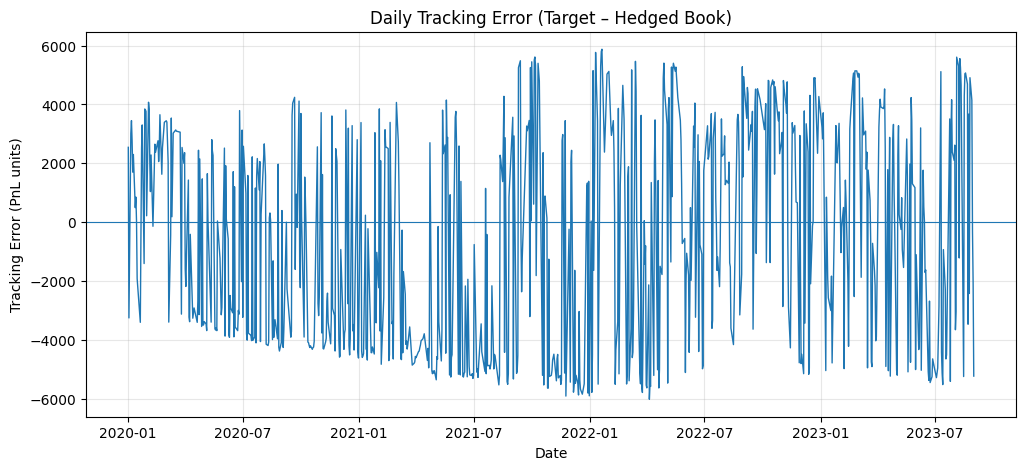

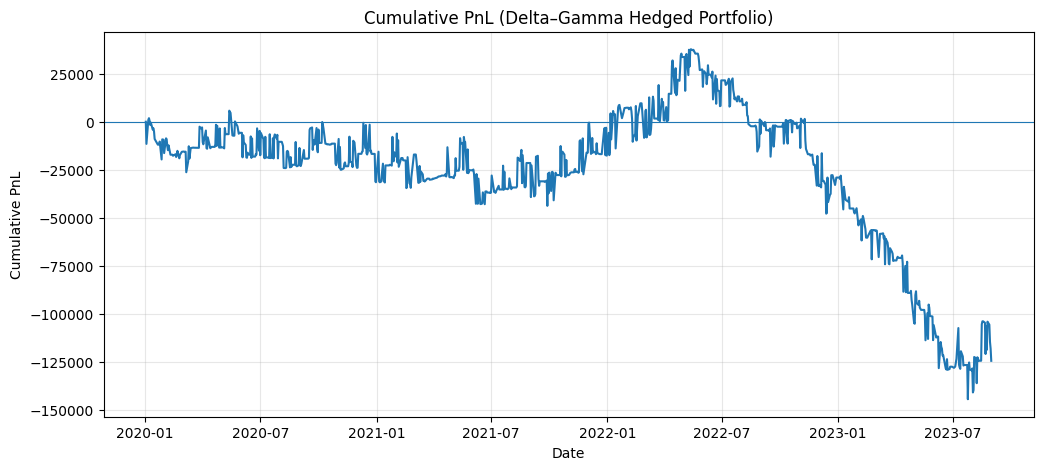

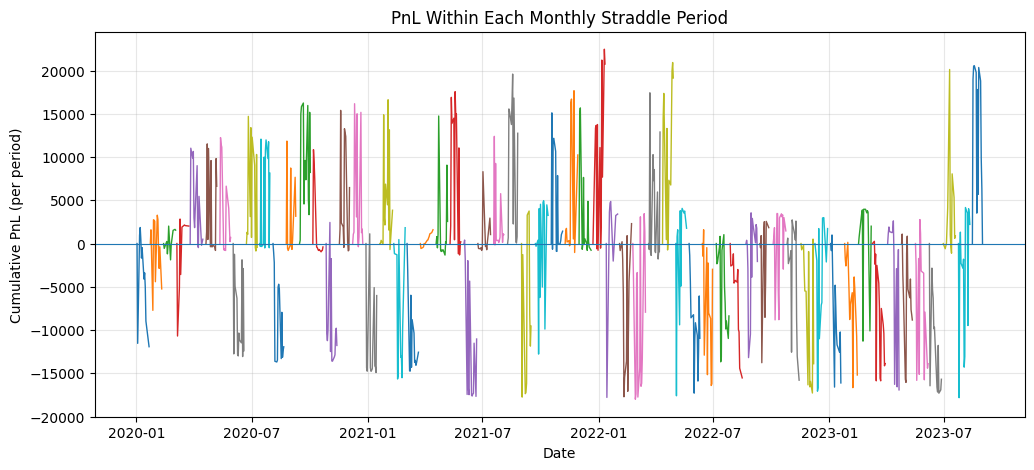

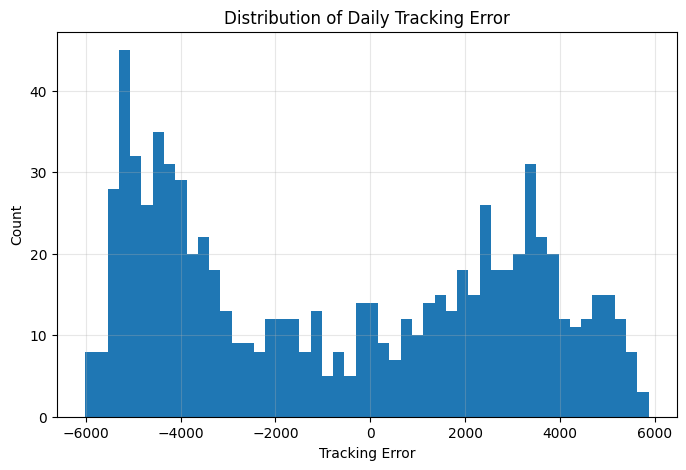

In [12]:
import matplotlib.pyplot as plt

# If you haven't created it yet:
bt = bt.sort_values("date").reset_index(drop=True)
if "cum_pnl" not in bt.columns:
    bt["cum_pnl"] = bt["daily_pnl"].cumsum()

# 1) Daily tracking error
plt.figure(figsize=(12,5))
plt.plot(bt["date"], bt["tracking_error"], lw=1)
plt.axhline(0, lw=0.8)
plt.title("Daily Tracking Error (Target – Hedged Book)")
plt.xlabel("Date"); plt.ylabel("Tracking Error (PnL units)")
plt.grid(True, alpha=0.3)
plt.show()

# 2) Cumulative PnL over the whole backtest
plt.figure(figsize=(12,5))
plt.plot(bt["date"], bt["cum_pnl"], lw=1.5)
plt.axhline(0, lw=0.8)
plt.title("Cumulative PnL (Delta–Gamma Hedged Portfolio)")
plt.xlabel("Date"); plt.ylabel("Cumulative PnL")
plt.grid(True, alpha=0.3)
plt.show()

# 3) Cumulative PnL reset each 1-month period (non-overlapping)
plt.figure(figsize=(12,5))
for period, sub in bt.groupby("period_start", sort=True):
    sub = sub.sort_values("date").copy()
    sub["cum_pnl_period"] = sub["daily_pnl"].cumsum()
    plt.plot(sub["date"], sub["cum_pnl_period"], lw=1)
plt.axhline(0, lw=0.8)
plt.title("PnL Within Each Monthly Straddle Period")
plt.xlabel("Date"); plt.ylabel("Cumulative PnL (per period)")
plt.grid(True, alpha=0.3)
plt.show()

# 4) (Optional) Histogram of tracking error
plt.figure(figsize=(8,5))
plt.hist(bt["tracking_error"].dropna(), bins=50)
plt.title("Distribution of Daily Tracking Error")
plt.xlabel("Tracking Error"); plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

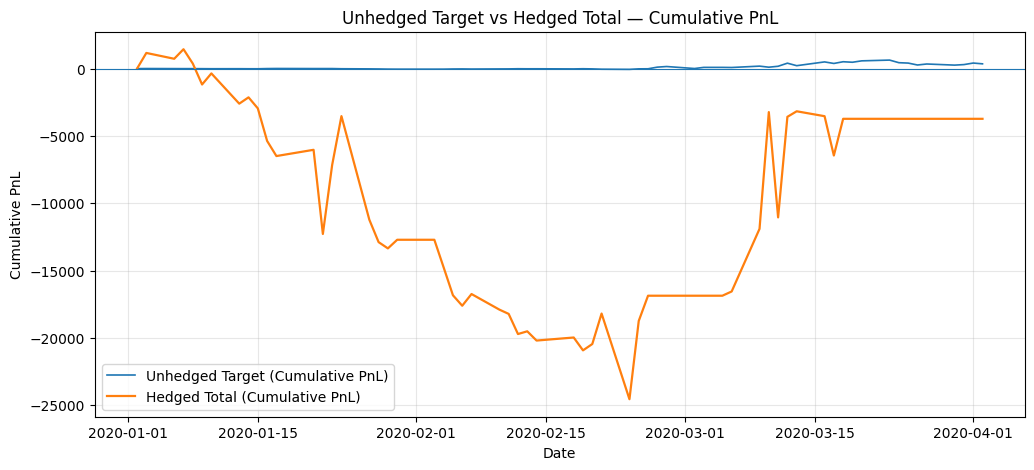

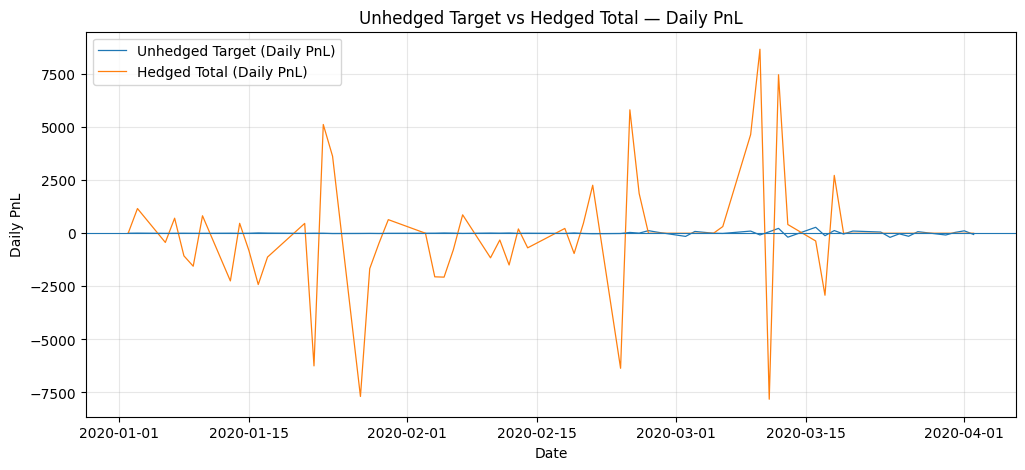

In [10]:
import matplotlib.pyplot as plt

# Ensure chronological order
bt = bt.sort_values("date").reset_index(drop=True)

# Unhedged target PnL: day-over-day change in the straddle's marked value
bt["unhedged_daily_pnl"] = bt.groupby("period_start")["V_value"].diff().fillna(0.0)

# Hedged PnL is already your daily_pnl from the combined book
bt["hedged_daily_pnl"] = bt["daily_pnl"].fillna(0.0)

# Cumulative PnL (overall; both start from 0 at the very beginning)
bt["unhedged_cum_pnl"] = bt["unhedged_daily_pnl"].cumsum()
bt["hedged_cum_pnl"]   = bt["hedged_daily_pnl"].cumsum()

# ---- Overlay: cumulative PnL (unhedged vs hedged) ----
plt.figure(figsize=(12,5))
plt.plot(bt["date"], bt["unhedged_cum_pnl"], label="Unhedged Target (Cumulative PnL)", lw=1.2)
plt.plot(bt["date"], bt["hedged_cum_pnl"],   label="Hedged Total (Cumulative PnL)", lw=1.6)
plt.axhline(0, lw=0.8)
plt.title("Unhedged Target vs Hedged Total — Cumulative PnL")
plt.xlabel("Date"); plt.ylabel("Cumulative PnL")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---- (Optional) Overlay: daily PnL time series ----
plt.figure(figsize=(12,5))
plt.plot(bt["date"], bt["unhedged_daily_pnl"], label="Unhedged Target (Daily PnL)", lw=0.9)
plt.plot(bt["date"], bt["hedged_daily_pnl"],   label="Hedged Total (Daily PnL)", lw=0.9)
plt.axhline(0, lw=0.8)
plt.title("Unhedged Target vs Hedged Total — Daily PnL")
plt.xlabel("Date"); plt.ylabel("Daily PnL")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()